<a href="https://colab.research.google.com/github/SouparnaChatterjee/AUTOMATION/blob/main/object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


0: 384x640 13 cars, 511.8ms
Speed: 4.0ms preprocess, 511.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


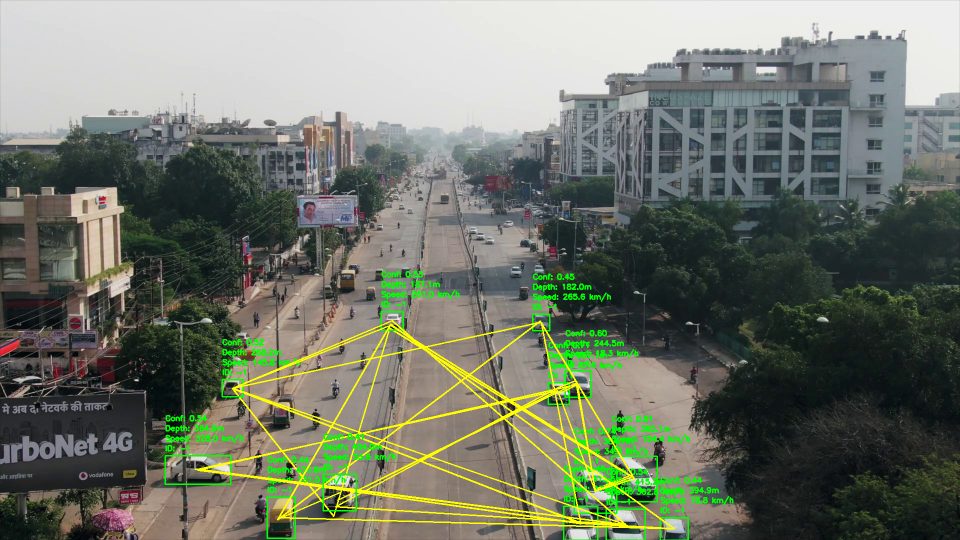


0: 384x640 12 cars, 403.2ms
Speed: 11.2ms preprocess, 403.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


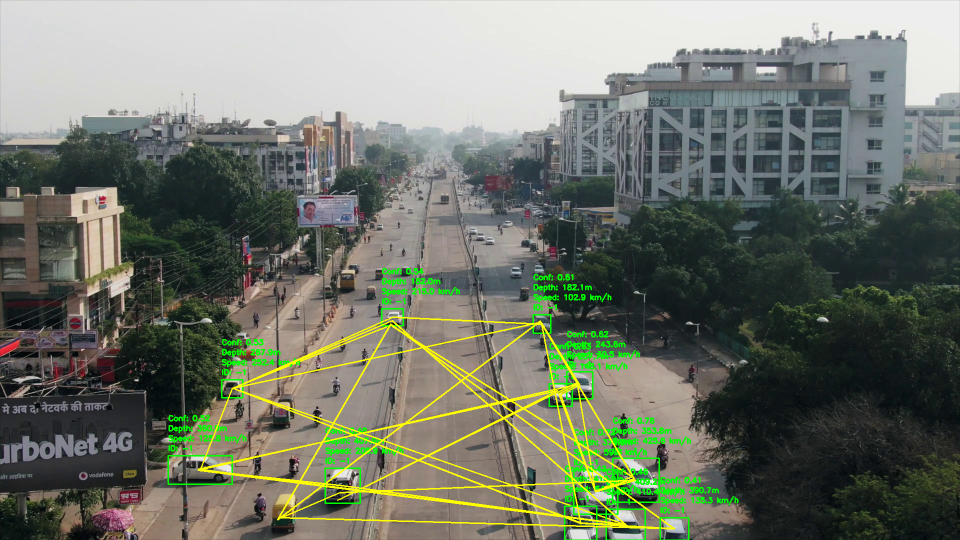

Processing complete
Output saved as: processed_aerial_traffic.mp4


In [1]:
# Initial setup and imports
!pip install torch torchvision ultralytics timm
!pip install -q opencv-python matplotlib gdown

# Install MiDaS properly
!git clone https://github.com/isl-org/MiDaS.git
!pip install -q -r MiDaS/requirements.txt

import torch
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from ultralytics import YOLO
import time
import os
import sys

# Add MiDaS to Python path
sys.path.append('./MiDaS')

# Download the video using gdown
!gdown --id 12e8OlHSJ4B1PXDSKxUkDA6hHYUpV5UMV -O aerial_traffic.mp4

class AerialTrafficDetector:
    def __init__(self):
        self.yolo_model = YOLO('yolov5su.pt')

        try:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            print(f"Using device: {self.device}")

            # Load MiDaS model
            model_type = "MiDaS_small"
            self.midas = torch.hub.load("intel-isl/MiDaS", model_type)
            self.midas.to(self.device)
            self.midas.eval()

            # Load transforms
            self.midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
            self.transform = self.midas_transforms.small_transform

        except Exception as e:
            print(f"Error initializing MiDaS: {str(e)}")
            raise

        self.previous_positions = {}
        self.track_history = {}
        self.previous_time = time.time()
        self.scale_factor = 0.2
        self.track_length = 30

    def calculate_speed(self, current_pos, previous_pos, time_diff):
        if time_diff <= 0:
            return 0

        pixel_distance = np.sqrt(
            (current_pos[0] - previous_pos[0])**2 +
            (current_pos[1] - previous_pos[1])**2
        )
        meters = pixel_distance * self.scale_factor
        return (meters / time_diff) * 3.6  # Convert to km/h

    def update_trajectory(self, obj_id, center):
        if obj_id not in self.track_history:
            self.track_history[obj_id] = []

        self.track_history[obj_id].append(center)

        if len(self.track_history[obj_id]) > self.track_length:
            self.track_history[obj_id].pop(0)

    def draw_trajectory(self, frame, obj_id):
        if obj_id in self.track_history and len(self.track_history[obj_id]) > 1:
            points = np.array(self.track_history[obj_id], dtype=np.int32)
            cv2.polylines(frame, [points], False, (0, 255, 255), 2)

    def process_frame(self, frame):
        current_time = time.time()

        # YOLO Detection
        results = self.yolo_model(frame, classes=[2, 3, 5, 7], conf=0.4)

        # Depth Estimation
        input_batch = self.transform(frame).to(self.device)
        with torch.no_grad():
            prediction = self.midas(input_batch)
            prediction = torch.nn.functional.interpolate(
                prediction.unsqueeze(1),
                size=frame.shape[:2],
                mode="bicubic",
                align_corners=False,
            ).squeeze()
        depth_map = prediction.cpu().numpy()

        annotated_frame = frame.copy()

        for r in results:
            boxes = r.boxes
            for box in boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                center = (int((x1 + x2) / 2), int((y1 + y2) / 2))

                obj_id = int(box.id) if box.id is not None else -1
                conf = float(box.conf)

                speed = 0
                if obj_id in self.previous_positions:
                    prev_pos = self.previous_positions[obj_id]
                    time_diff = current_time - self.previous_time
                    speed = self.calculate_speed(center, prev_pos, time_diff)

                self.previous_positions[obj_id] = center
                self.update_trajectory(obj_id, center)
                self.draw_trajectory(annotated_frame, obj_id)

                obj_depth = np.mean(depth_map[int(y1):int(y2), int(x1):int(x2)])

                cv2.rectangle(annotated_frame,
                            (int(x1), int(y1)),
                            (int(x2), int(y2)),
                            (0, 255, 0), 2)

                info_text = [
                    f'ID: {obj_id}',
                    f'Speed: {speed:.1f} km/h',
                    f'Depth: {obj_depth:.1f}m',
                    f'Conf: {conf:.2f}'
                ]

                for i, text in enumerate(info_text):
                    cv2.putText(annotated_frame,
                              text,
                              (int(x1), int(y1) - 10 - (i * 20)),
                              cv2.FONT_HERSHEY_SIMPLEX,
                              0.5, (0, 255, 0), 2)

        self.previous_time = current_time
        return annotated_frame, depth_map

def process_video(video_path):
    try:
        detector = AerialTrafficDetector()
    except Exception as e:
        print(f"Error creating detector: {str(e)}")
        return

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file: {video_path}")
        return

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"Video properties: {frame_width}x{frame_height} @ {fps}fps")

    out = cv2.VideoWriter('processed_aerial_traffic.mp4',
                         cv2.VideoWriter_fourcc(*'mp4v'),
                         fps,
                         (frame_width, frame_height))

    frame_count = 0
    processing_interval = 3  # Process every 3rd frame

    try:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            frame_count += 1
            if frame_count % processing_interval != 0:
                continue

            processed_frame, depth_map = detector.process_frame(frame)
            out.write(processed_frame)

            if frame_count % 30 == 0:
                progress = (frame_count / total_frames) * 100
                print(f"Processing: {progress:.1f}% complete")

            display_frame = cv2.resize(processed_frame, (960, 540))
            cv2_imshow(display_frame)

            if frame_count % 30 == 0:
                plt.figure(figsize=(10, 6))
                plt.imshow(depth_map, cmap='plasma')
                plt.colorbar(label='Depth')
                plt.title('Depth Map')
                plt.show()

            if frame_count % 10 == 0:
                from IPython.display import clear_output
                clear_output(wait=True)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    except Exception as e:
        print(f"Error during processing: {str(e)}")

    finally:
        cap.release()
        out.release()
        cv2.destroyAllWindows()
        print("Processing complete")
        print(f"Output saved as: processed_aerial_traffic.mp4")

# Main execution
if __name__ == "__main__":
    video_path = 'aerial_traffic.mp4'

    if not os.path.exists(video_path):
        print(f"Error: Video file not found at {video_path}")
        exit()

    print(f"Starting video processing: {video_path}")
    try:
        process_video(video_path)
    except Exception as e:
        print(f"Error during video processing: {str(e)}")

In [2]:
# Initial setup and imports
!pip install torch torchvision ultralytics timm
!pip install -q opencv-python matplotlib gdown

# Install MiDaS properly
!git clone https://github.com/isl-org/MiDaS.git
!pip install -q -r MiDaS/requirements.txt

import torch
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from ultralytics import YOLO
import time
import os
import sys

# Add MiDaS to Python path
sys.path.append('./MiDaS')

# Download the video using gdown
!gdown --id 12e8OlHSJ4B1PXDSKxUkDA6hHYUpV5UMV -O aerial_traffic.mp4

# COCO class names
COCO_CLASSES = {
    0: 'person',
    1: 'bicycle',
    2: 'car',
    3: 'motorcycle',
    4: 'airplane',
    5: 'bus',
    6: 'train',
    7: 'truck',
    8: 'boat'
}

# Colors for different classes (BGR format)
COLORS = {
    'person': (0, 255, 255),    # Yellow
    'car': (0, 255, 0),         # Green
    'bus': (255, 0, 0),         # Blue
    'truck': (0, 0, 255),       # Red
    'motorcycle': (255, 255, 0), # Cyan
    'bicycle': (255, 0, 255),    # Magenta
    'default': (128, 128, 128)   # Gray
}

class AerialTrafficDetector:
    def __init__(self):
        # Initialize YOLO with COCO dataset
        self.yolo_model = YOLO('yolov8x.pt')  # Using YOLOv8x for better accuracy

        try:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            print(f"Using device: {self.device}")

            # Load MiDaS model
            model_type = "MiDaS_small"
            self.midas = torch.hub.load("intel-isl/MiDaS", model_type)
            self.midas.to(self.device)
            self.midas.eval()

            # Load transforms
            self.midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
            self.transform = self.midas_transforms.small_transform

        except Exception as e:
            print(f"Error initializing MiDaS: {str(e)}")
            raise

        self.previous_positions = {}
        self.track_history = {}
        self.previous_time = time.time()
        self.scale_factor = 0.2
        self.track_length = 30
        self.class_counts = {cls_name: 0 for cls_name in COCO_CLASSES.values()}

    def get_color(self, class_name):
        return COLORS.get(class_name, COLORS['default'])

    def calculate_speed(self, current_pos, previous_pos, time_diff):
        if time_diff <= 0:
            return 0

        pixel_distance = np.sqrt(
            (current_pos[0] - previous_pos[0])**2 +
            (current_pos[1] - previous_pos[1])**2
        )
        meters = pixel_distance * self.scale_factor
        return (meters / time_diff) * 3.6  # Convert to km/h

    def update_trajectory(self, obj_id, center, class_name):
        if obj_id not in self.track_history:
            self.track_history[obj_id] = {'positions': [], 'class': class_name}

        self.track_history[obj_id]['positions'].append(center)

        if len(self.track_history[obj_id]['positions']) > self.track_length:
            self.track_history[obj_id]['positions'].pop(0)

    def draw_trajectory(self, frame, obj_id):
        if obj_id in self.track_history and len(self.track_history[obj_id]['positions']) > 1:
            points = np.array(self.track_history[obj_id]['positions'], dtype=np.int32)
            class_name = self.track_history[obj_id]['class']
            color = self.get_color(class_name)
            cv2.polylines(frame, [points], False, color, 2)

    def process_frame(self, frame):
        current_time = time.time()

        # Reset class counts
        self.class_counts = {cls_name: 0 for cls_name in COCO_CLASSES.values()}

        # YOLO Detection
        results = self.yolo_model(frame, conf=0.3)  # Lower confidence threshold for better detection

        # Depth Estimation
        input_batch = self.transform(frame).to(self.device)
        with torch.no_grad():
            prediction = self.midas(input_batch)
            prediction = torch.nn.functional.interpolate(
                prediction.unsqueeze(1),
                size=frame.shape[:2],
                mode="bicubic",
                align_corners=False,
            ).squeeze()
        depth_map = prediction.cpu().numpy()

        annotated_frame = frame.copy()

        # Draw detection counts
        y_offset = 30
        for cls_name in COCO_CLASSES.values():
            color = self.get_color(cls_name)
            cv2.putText(annotated_frame,
                       f'{cls_name}: {self.class_counts[cls_name]}',
                       (10, y_offset),
                       cv2.FONT_HERSHEY_SIMPLEX,
                       0.6, color, 2)
            y_offset += 25

        for r in results:
            boxes = r.boxes
            for box in boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                center = (int((x1 + x2) / 2), int((y1 + y2) / 2))

                obj_id = int(box.id) if box.id is not None else -1
                conf = float(box.conf)
                cls_id = int(box.cls)

                # Get class name
                class_name = COCO_CLASSES.get(cls_id, 'unknown')
                self.class_counts[class_name] += 1

                # Get color for this class
                color = self.get_color(class_name)

                speed = 0
                if obj_id in self.previous_positions:
                    prev_pos = self.previous_positions[obj_id]
                    time_diff = current_time - self.previous_time
                    speed = self.calculate_speed(center, prev_pos, time_diff)

                self.previous_positions[obj_id] = center
                self.update_trajectory(obj_id, center, class_name)
                self.draw_trajectory(annotated_frame, obj_id)

                obj_depth = np.mean(depth_map[int(y1):int(y2), int(x1):int(x2)])

                # Draw bounding box with class-specific color
                cv2.rectangle(annotated_frame,
                            (int(x1), int(y1)),
                            (int(x2), int(y2)),
                            color, 2)

                info_text = [
                    f'{class_name} ID: {obj_id}',
                    f'Speed: {speed:.1f} km/h',
                    f'Depth: {obj_depth:.1f}m',
                    f'Conf: {conf:.2f}'
                ]

                for i, text in enumerate(info_text):
                    cv2.putText(annotated_frame,
                              text,
                              (int(x1), int(y1) - 10 - (i * 20)),
                              cv2.FONT_HERSHEY_SIMPLEX,
                              0.5, color, 2)

        self.previous_time = current_time
        return annotated_frame, depth_map

def process_video(video_path):
    try:
        detector = AerialTrafficDetector()
    except Exception as e:
        print(f"Error creating detector: {str(e)}")
        return

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file: {video_path}")
        return

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"Video properties: {frame_width}x{frame_height} @ {fps}fps")

    out = cv2.VideoWriter('processed_aerial_traffic.mp4',
                         cv2.VideoWriter_fourcc(*'mp4v'),
                         fps,
                         (frame_width, frame_height))

    frame_count = 0
    processing_interval = 3  # Process every 3rd frame

    try:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            frame_count += 1
            if frame_count % processing_interval != 0:
                continue

            processed_frame, depth_map = detector.process_frame(frame)
            out.write(processed_frame)

            if frame_count % 30 == 0:
                progress = (frame_count / total_frames) * 100
                print(f"Processing: {progress:.1f}% complete")

            display_frame = cv2.resize(processed_frame, (960, 540))
            cv2_imshow(display_frame)

            if frame_count % 30 == 0:
                plt.figure(figsize=(10, 6))
                plt.imshow(depth_map, cmap='plasma')
                plt.colorbar(label='Depth')
                plt.title('Depth Map')
                plt.show()

            if frame_count % 10 == 0:
                from IPython.display import clear_output
                clear_output(wait=True)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    except Exception as e:
        print(f"Error during processing: {str(e)}")

    finally:
        cap.release()
        out.release()
        cv2.destroyAllWindows()
        print("Processing complete")
        print(f"Output saved as: processed_aerial_traffic.mp4")

# Main execution
if __name__ == "__main__":
    video_path = 'aerial_traffic.mp4'

    if not os.path.exists(video_path):
        print(f"Error: Video file not found at {video_path}")
        exit()

    print(f"Starting video processing: {video_path}")
    try:
        process_video(video_path)
    except Exception as e:
        print(f"Error during video processing: {str(e)}")

fatal: destination path 'MiDaS' already exists and is not an empty directory.
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'MiDaS/requirements.txt'
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=12e8OlHSJ4B1PXDSKxUkDA6hHYUpV5UMV
To: /content/aerial_traffic.mp4
100% 15.5M/15.5M [00:00<00:00, 177MB/s]
Starting video processing: aerial_traffic.mp4


100%|██████████| 131M/131M [00:00<00:00, 257MB/s]


Using device: cpu


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Video properties: 1920x1080 @ 24fps

0: 384x640 6 persons, 16 cars, 1 bus, 2 trucks, 1 traffic light, 2759.4ms
Speed: 4.8ms preprocess, 2759.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Error during processing: 'unknown'
Processing complete
Output saved as: processed_aerial_traffic.mp4
